In [ ]:
import os, sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import cv2
from PIL import Image
import clip
import torch
from torchvision.ops import nms

ImportError: attempted relative import with no known parent package

In [ ]:
from xpose.models import build_model
# from predefined_keypoints import person as person_keyp, face as face_keyp
from xpose.util import transforms as T
from xpose.util import box_ops
from xpose.util.config import Config
from xpose.util.predefined_keypoints import person as person_keyp, face as face_keyp

/opt/conda/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [4]:
model_config_path = "xpose/config/UniPose_SwinT.py"
model_checkpoint_path = "xpose/weights/unipose_swint.pth"
args = Config.fromfile(model_config_path)
args.device = "cuda"

model = build_model(args)
checkpoint = torch.load(model_checkpoint_path, weights_only=False)['model']
load_res = model.load_state_dict(checkpoint, strict=False)
print(load_res)
_ = model.eval()
model = model.to('cuda')

use_checkpoint!!!!!!!!!!!!!!!!!!!!!!!!
********* sub_sentence_present True
_IncompatibleKeys(missing_keys=['clip_model.positional_embedding', 'clip_model.text_projection', 'clip_model.logit_scale', 'clip_model.transformer.resblocks.0.attn.in_proj_weight', 'clip_model.transformer.resblocks.0.attn.in_proj_bias', 'clip_model.transformer.resblocks.0.attn.out_proj.weight', 'clip_model.transformer.resblocks.0.attn.out_proj.bias', 'clip_model.transformer.resblocks.0.ln_1.weight', 'clip_model.transformer.resblocks.0.ln_1.bias', 'clip_model.transformer.resblocks.0.mlp.c_fc.weight', 'clip_model.transformer.resblocks.0.mlp.c_fc.bias', 'clip_model.transformer.resblocks.0.mlp.c_proj.weight', 'clip_model.transformer.resblocks.0.mlp.c_proj.bias', 'clip_model.transformer.resblocks.0.ln_2.weight', 'clip_model.transformer.resblocks.0.ln_2.bias', 'clip_model.transformer.resblocks.1.attn.in_proj_weight', 'clip_model.transformer.resblocks.1.attn.in_proj_bias', 'clip_model.transformer.resblocks.1.attn.out_p

In [8]:
image_path = "/data/whisperer/datasets/comics/CoMix/tmp4.png"

image_pil = Image.open(image_path).convert("RGB")
W, H = image_pil.size
transform = T.Compose([
    T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
image, _ = transform(image_pil, None)
image = image.to("cuda")

In [9]:
instance_text_prompt = ["face"]
keypoint_text_prompt = face_keyp['keypoints']
box_threshold = 0.1
iou_threshold = 0.1

with torch.no_grad():
    instance_descriptions = [
        f"a photo of {cat.lower().replace('_', ' ').replace('-', ' ')}"
        for cat in instance_text_prompt
    ]
    ins_text_embeddings = torch.cat([
        model.clip_model.encode_text(clip.tokenize(ins_dec).to("cuda")) 
        for ins_dec in instance_descriptions
    ], dim=0)

    keypoint_descriptions = [
        f"a photo of {cat.lower().replace('_', ' ')}"
        for cat in keypoint_text_prompt
    ]
    kpt_text_embeddings = torch.cat([
        model.clip_model.encode_text(clip.tokenize(kpt_dec).to("cuda")) 
        for kpt_dec in keypoint_descriptions
    ], dim=0)
    
target = {
    "instance_text_prompt" : instance_text_prompt,
    "keypoint_text_prompt" : keypoint_text_prompt,
    "object_embeddings_text": ins_text_embeddings.float(),
    "kpts_embeddings_text" : torch.cat([
        kpt_text_embeddings.float(), 
        torch.zeros(100 - kpt_text_embeddings.shape[0], 512, dtype=torch.float32, device='cuda')
    ], dim=0),
    "kpt_vis_text" : torch.cat([
        torch.ones(kpt_text_embeddings.shape[0], device='cuda'),
        torch.zeros(100 - kpt_text_embeddings.shape[0],device='cuda')
    ], dim=0)
}

with torch.no_grad():
    outputs = model(image[None], [target])

logits = outputs["pred_logits"].sigmoid()[0].cpu()  # (nq, 256)
boxes = outputs["pred_boxes"][0].cpu()  # (nq, 4)
keypoints = outputs["pred_keypoints"][0][:,:2*len(keypoint_text_prompt)].cpu() # (nq, n_kpts * 2)

filt_mask = logits.max(dim=1)[0] > box_threshold
logits_filt, boxes_filt, keypoints_filt = logits[filt_mask], boxes[filt_mask], keypoints[filt_mask]  # num_filt, 256

keep_indices = nms(box_ops.box_cxcywh_to_xyxy(boxes_filt), logits_filt.max(dim=1)[0], iou_threshold=iou_threshold)
boxes_filt, keypoints_filt = boxes_filt[keep_indices], keypoints_filt[keep_indices]

print(keypoints_filt.shape)

/opt/conda/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


torch.Size([1, 136])


/data/whisperer/utils/pose_detection/dwpose/xpose/models/UniPose/deformable_transformer.py:1057: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


In [10]:
def coco17_to_openpose18(coco_kpts):
    """
    Convert COCO 17-keypoint annotation to OpenPose 18-keypoint format.

    Parameters
    ----------
    coco_kpts : array-like, shape (51,) or (17,3)
        COCO keypoints for one person: (x, y, v) for each of the 17 keypoints
        in the order [nose, left_eye, right_eye, left_ear, right_ear,
        left_shoulder, right_shoulder, left_elbow, right_elbow,
        left_wrist, right_wrist, left_hip, right_hip,
        left_knee, right_knee, left_ankle, right_ankle].

    Returns
    -------
    op_kpts : list of float, length 54
        OpenPose 18 keypoints: (x, y, v) for each keypoint in the order
        [nose, neck, R_shoulder, R_elbow, R_wrist, L_shoulder, L_elbow,
        L_wrist, R_hip, R_knee, R_ankle, L_hip, L_knee, L_ankle,
        R_eye, L_eye, R_ear, L_ear].
    """
    k = np.array(coco_kpts, dtype=float)
    if k.ndim == 1:
        k = k.reshape(17, -1)
    elif k.shape[0] != 17:
        raise ValueError("Expected coco_kpts of shape (51,) or (17,3)")

    op = np.zeros((18, 2), dtype=float)

    # 0: Nose
    op[0] = k[0]

    # 1: Neck = midpoint of shoulders
    left_sh  = k[5]
    right_sh = k[6]
    op[1, :2] = (left_sh[:2] + right_sh[:2]) / 2
    # visibility: use max of shoulders (if either shoulder is labeled/visible)
    op[1, 2] = max(left_sh[2], right_sh[2])

    # mapping of the remaining OpenPose indices to COCO indices
    mapping = {
        2: 6,   # R_shoulder
        3: 8,   # R_elbow
        4: 10,  # R_wrist
        5: 5,   # L_shoulder
        6: 7,   # L_elbow
        7: 9,   # L_wrist
        8: 12,  # R_hip
        9: 14,  # R_knee
        10:16,  # R_ankle
        11:11,  # L_hip
        12:13,  # L_knee
        13:15,  # L_ankle
        14:2,   # R_eye
        15:1,   # L_eye
        16:4,   # R_ear
        17:3    # L_ear
    }

    for op_idx, coco_idx in mapping.items():
        op[op_idx] = k[coco_idx]

    return op.reshape(-1).tolist()

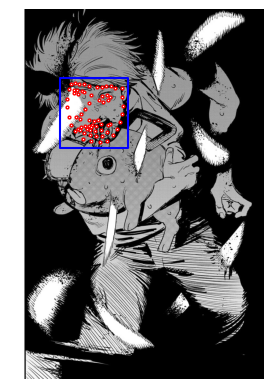

In [11]:
input_img = image_pil
# input_img = Image.new("RGB", (W, H), (0,0,0))
fig, ax = plt.subplots(frameon=False)
# plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax.imshow(input_img, aspect='equal')

boxes_resized = [torch.tensor([(box[0]-box[2]/2)*W, (box[1]-box[3]/2)*H, box[2]*W, box[3]*H]) for box in boxes_filt.cpu()]
rectangles = PatchCollection(
    [Rectangle((box[0], box[1]), box[2], box[3]) for box in boxes_resized],
    facecolor='none', linestyle="-", edgecolors=(0.0,0.0,1.0), linewidths=1.5
)
ax.add_collection(rectangles)

keypoints_resize = [(keyp_filt.reshape(-1,2) * torch.tensor([W, H])).cpu().numpy() for keyp_filt in keypoints_filt]
for keypoint in keypoints_resize:
    for keyp in keypoint:
        ax.plot(keyp[0], keyp[1], 'o', markersize=2, markerfacecolor=(1,1,1), markeredgecolor='r')

ax.set_axis_off()
plt.show()